In [51]:
import pandas as pd
import urllib.request
import folium
import webbrowser
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

url = "https://s3.eu-west-1.amazonaws.com/course.oc-static.com/projects/Data_Scientist_P4/2016_Building_Energy_Benchmarking.csv"
urllib.request.urlretrieve(url, "2016_Building_Energy_Benchmarking.csv")
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_rows', None)


In [2]:
data = pd.read_csv('2016_Building_Energy_Benchmarking.csv')

In [3]:
def create_barplot(ax, data, col):
    plot_data = data[col].value_counts()
    sns.barplot(x=plot_data.index, y=plot_data.values, ax=ax)
    ax.set_title(f'Count of {col}')
    ax.tick_params(axis='x', rotation=90, labelright=False)
    

def plot_barplots(data, columns):
    num_cols = len(columns)
    
    fig, axes = plt.subplots(num_cols, 1, figsize=(15, 5 * num_cols))
    axes = np.array(axes).flatten()
    
    list(map(create_barplot, axes[:num_cols], [data]*num_cols, columns))
    plt.tight_layout(pad=3.0)
    plt.show()

In [4]:
def NanHeatmap(data):
	plt.figure(figsize=(12, 10))
	sns.heatmap(data.isnull(), cbar=False)
	plt.xticks(rotation=45, ha='right')
	plt.title('Missing values heatmap')
	plt.show()

In [5]:
def create_boxplot(ax, data, col):
    sns.boxplot(x=data[col], ax=ax)
    ax.set_title(f'Distribution of {col}')

def plot_boxplots(data, columns):
    num_cols = len(columns)
    num_rows = num_cols // 2 + (num_cols % 2 > 0)
    
    fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5 * num_rows))
    axes = np.array(axes).flatten()
    
    list(map(create_boxplot, axes[:num_cols], [data]*num_cols, columns))
    
    plt.tight_layout()
    plt.show()

In [54]:
def plot_scaler(data, col, categories=None):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data[col])

    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    print(f'Cumulative variance ratio for 2 components: {cumulative_variance_ratio[1]*100:.2f}%')
    print(f'component 3: {explained_variance_ratio[2]*100:.2f}%')

    fig, ax = plt.subplots(2, 2, figsize=(16, 12))
    ax[0, 0].bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
    ax[0, 0].set_xlabel('Principal Component')
    ax[0, 0].set_ylabel('Explained Variance Ratio')
    ax[0, 0].set_title('Explained Variance Ratio by Principal Component')
    
    ax[0, 1].plot(range(1, len(pca.explained_variance_ratio_) + 1), cumulative_variance_ratio)
    ax[0, 1].set_xlabel('Number of components')
    ax[0, 1].set_ylabel('Cumulative explained variance')
    ax[0, 1].set_title('Scree Plot')


    feature_names = data[col].columns
    if len(feature_names) > 2:
        for i in range(len(feature_names)):
            ax[1, 0].arrow(0, 0, pca.components_[0, i], pca.components_[1, i], 
                           head_width=0.05, head_length=0.05, color='blue')
    
        for i, feature in enumerate(feature_names):
            ax[1, 0].text(pca.components_[0, i] * 1.15, pca.components_[1, i] * 1.15, feature,
                          color='black', ha='center', va='center')
    
        ax[1, 0].set_xlim(-1, 1)
        ax[1, 0].set_ylim(-1, 1)
        ax[1, 0].set_xlabel('Principal Component 1')
        ax[1, 0].set_ylabel('Principal Component 2')
        ax[1, 0].set_title('Correlation Circle')
        ax[1, 0].grid()

    if categories is not None:
        scatter = ax[1, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=categories, cmap='viridis', alpha=0.5)
        ax[1, 1].set_xlabel('First principal component')
        ax[1, 1].set_ylabel('Second principal component')
        ax[1, 1].set_title('Projection of Individuals')
        cbar = plt.colorbar(scatter, ax=ax[1, 1], label='Category')
    plt.tight_layout()
    plt.show()

In [6]:
def draw_map(data):
    color_dict = {
        'NonResidential': 'blue',
        'Multifamily LR (1-4)': 'green',
        'Multifamily MR (5-9)': 'red',
        'Multifamily HR (10+)': 'purple',
        'SPS-District K-12': 'gray',
        'Campus': 'black',
        'Nonresidential COS': 'orange',
        'Nonresidential WA': 'pink'
    }

    seattle_coords = [47.6062, -122.3321]
    mymap = folium.Map(location=seattle_coords, zoom_start=12)
    for index, row in data.iterrows():
        folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            popup=row['BuildingType'],
            icon=folium.Icon(color=color_dict.get(row['BuildingType'], 'white'))
        ).add_to(mymap)
    mymap.save("map.html")
    webbrowser.open("map.html")

In [7]:
def treat_outliers(data, thresholds):
    data_clean = data.copy()
    for col, (min_val, max_val) in thresholds.items():
        if col in data.columns:
            data_clean = data_clean[(data_clean[col] > min_val) & (data_clean[col] <= max_val)]
    return data_clean

In [49]:

def create_boxplot_subplot(x, ax, var, data, y):
    sns.boxplot(x=x, y=var, data=pd.concat([data, y], axis=1), ax=ax)
    ax.set_title(f'{var} per nutri grade')
    ax.tick_params(axis='x', rotation=45, labelright=False)

def multi_boxplots(x, data, y, numeric_columns):
    num_cols = len(numeric_columns)
    fig, axes = plt.subplots(num_cols, 1, figsize=(15, 20))
    list(map(create_boxplot_subplot, [x] * num_cols, axes, numeric_columns, [data] * num_cols, [y] * num_cols))
    plt.tight_layout()
    plt.show()

In [40]:
def plot_pairplots(data, col):
	sns.set_theme(style="ticks")
	sns.pairplot(data[col], diag_kind="kde", markers="o", plot_kws={'alpha': 0.6})
	plt.tight_layout()
	plt.show()

In [8]:
def prepare_data(data, subset_dup, keep):
    data_cleaned = data.copy()
    if subset_dup:
        data_cleaned = data_cleaned.drop_duplicates(subset=subset_dup)
    else:
        print("No target for subsetDup.")
    if 'BuildingType' in data_cleaned.columns:
        data_cleaned['BuildingType'] = data_cleaned['BuildingType'].fillna('')
        data_to_del = data_cleaned[data_cleaned['BuildingType'].str.contains('Multifamily')].index
        data_cleaned = data_cleaned.drop(data_to_del)
    X = data_cleaned
    
    
    return X

In [9]:
var_list = data.columns.tolist()
print(var_list)
size_data = data.shape[0]
print(size_data)
missing_data = data.isnull().sum()/size_data
print(missing_data[missing_data
                   > 0.5])

['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType', 'PropertyName', 'Address', 'City', 'State', 'ZipCode', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus', 'Outlier', 'TotalGHGEmissions', 'GHGEmissionsIntensity']
3376
SecondLargestPropertyUseType      0.50
SecondLarge

In [34]:
subset_dup = ['OSEBuildingID']
filter = ['buildingType']
main_features = ['TotalGHGEmissions',
                 'SiteEnergyUse(kBtu)',
                ]
numeric_columns = ['NumberofBuildings',
                   'NumberofFloors',
                   'PropertyGFABuilding(s)',
                   'YearBuilt'   
                   ]
qualitative_columns = ['PrimaryPropertyType',
                       'BuildingType',
                       'Neighborhood',
                       ]


In [22]:
main_features = [col for col in main_features if col in data.columns]
numeric_columns = [col for col in numeric_columns if col in data.columns]
qualitative_columns = [col for col in qualitative_columns if col in data.columns]
feature_keep = main_features + numeric_columns + qualitative_columns
X_clean = prepare_data(data, subset_dup, feature_keep)

In [9]:
draw_map(X_clean)

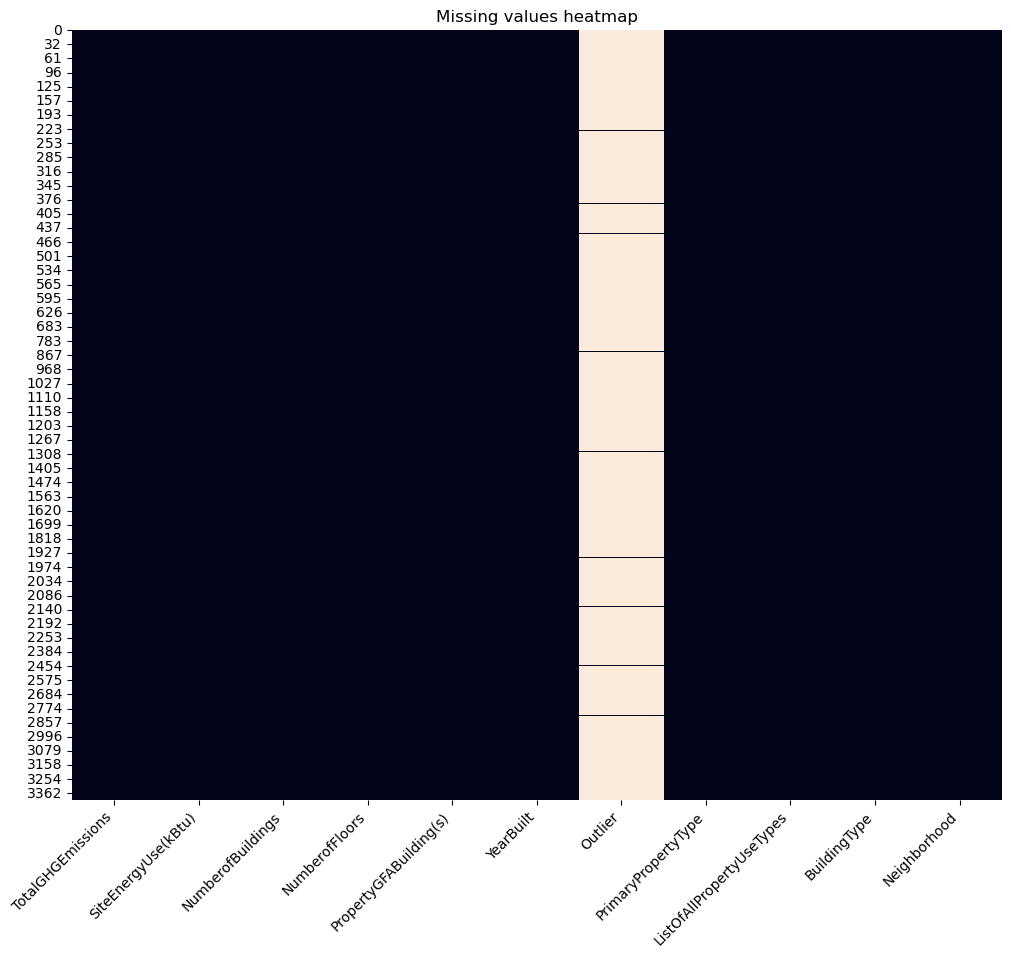

In [35]:
NanHeatmap(X_clean[feature_keep])

Drop the individuals this missing value in the main features (GHG Emissions, Site energy use)

In [23]:
rows_to_drop = X_clean.index[X_clean[main_features].isna().all(axis=1)]
X_clean = X_clean.drop(rows_to_drop)
print(f"Dropping {len(rows_to_drop)} rows with missing values in main features")

Dropping 2 rows with missing values in main features


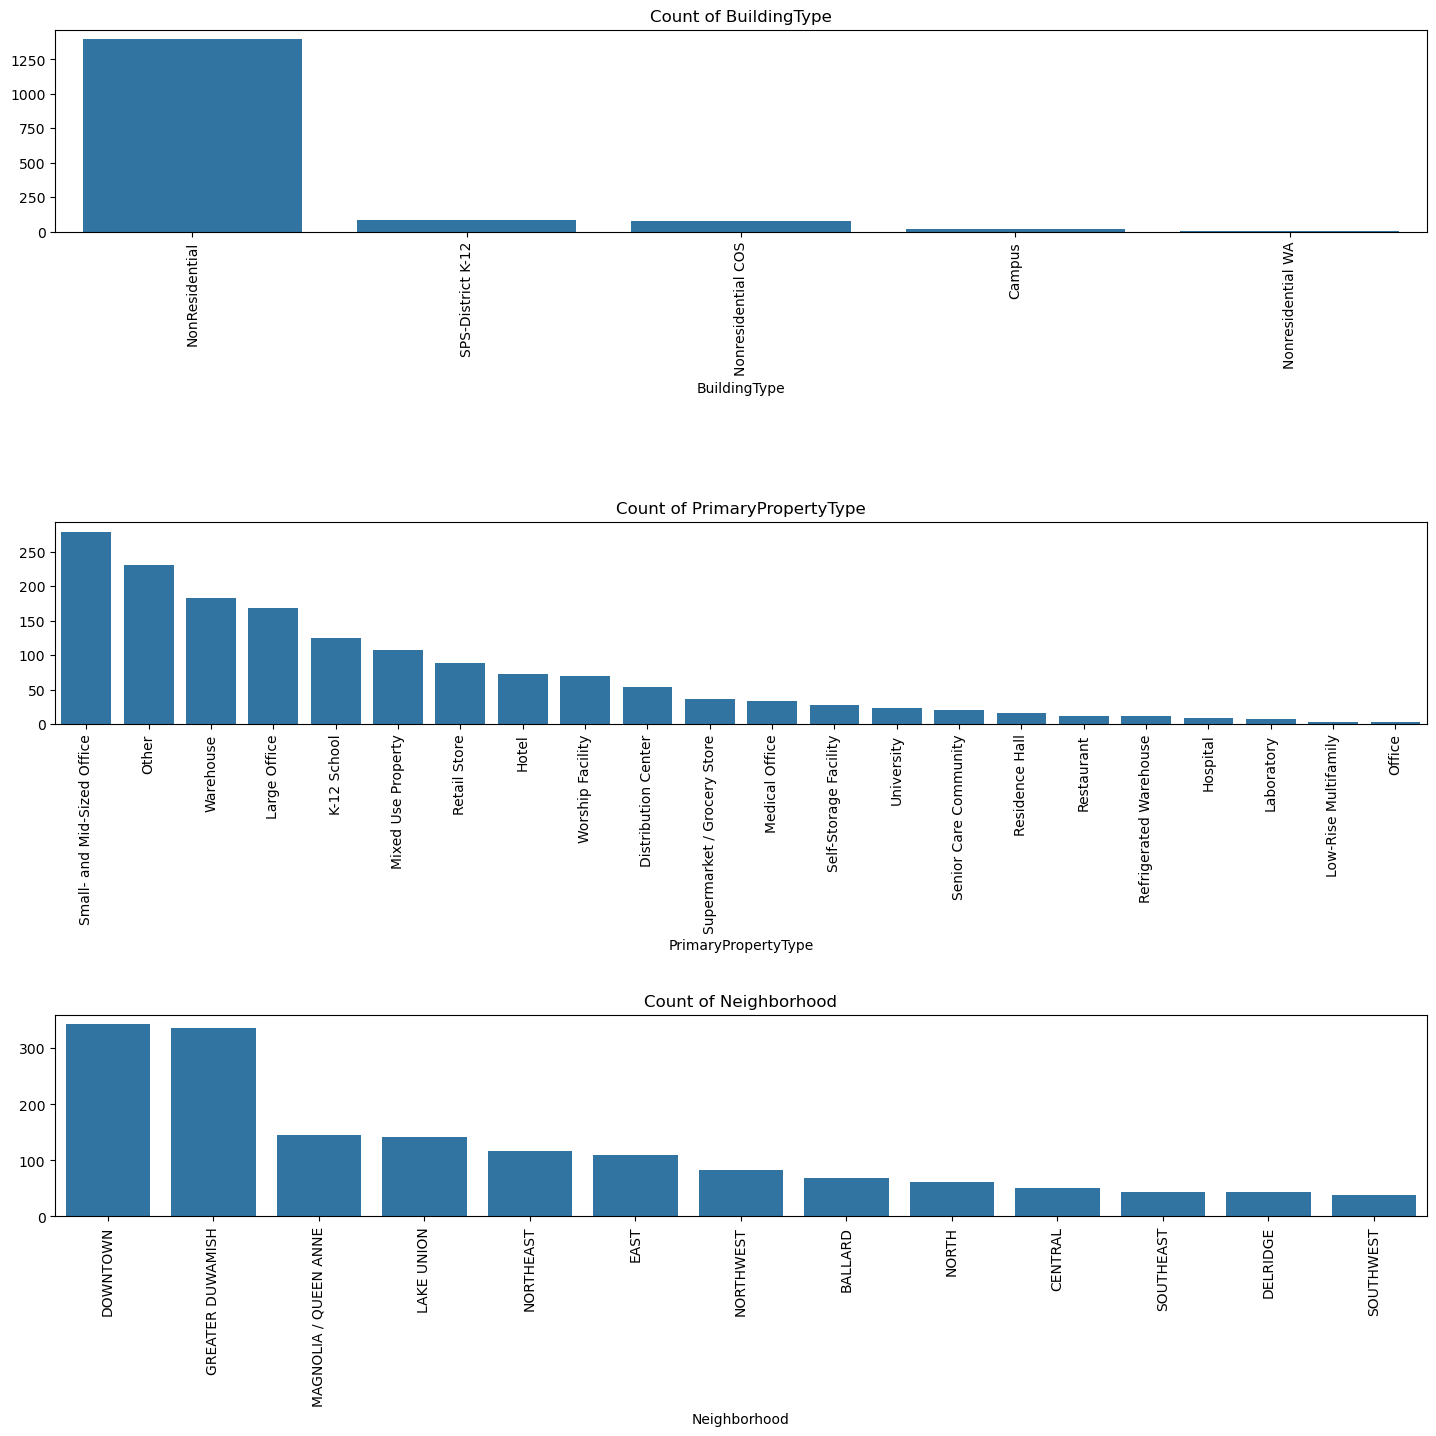

In [36]:
plot_barplots(X_clean, ['BuildingType', 'PrimaryPropertyType', 'Neighborhood'])

- For Neihborhood we need to group North with NORTH, central with CENTRAL ,ect ...
- For other i look more details

C:\Users\milan\AppData\Local\Temp\ipykernel_15880\4162418751.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(pad=3.0)


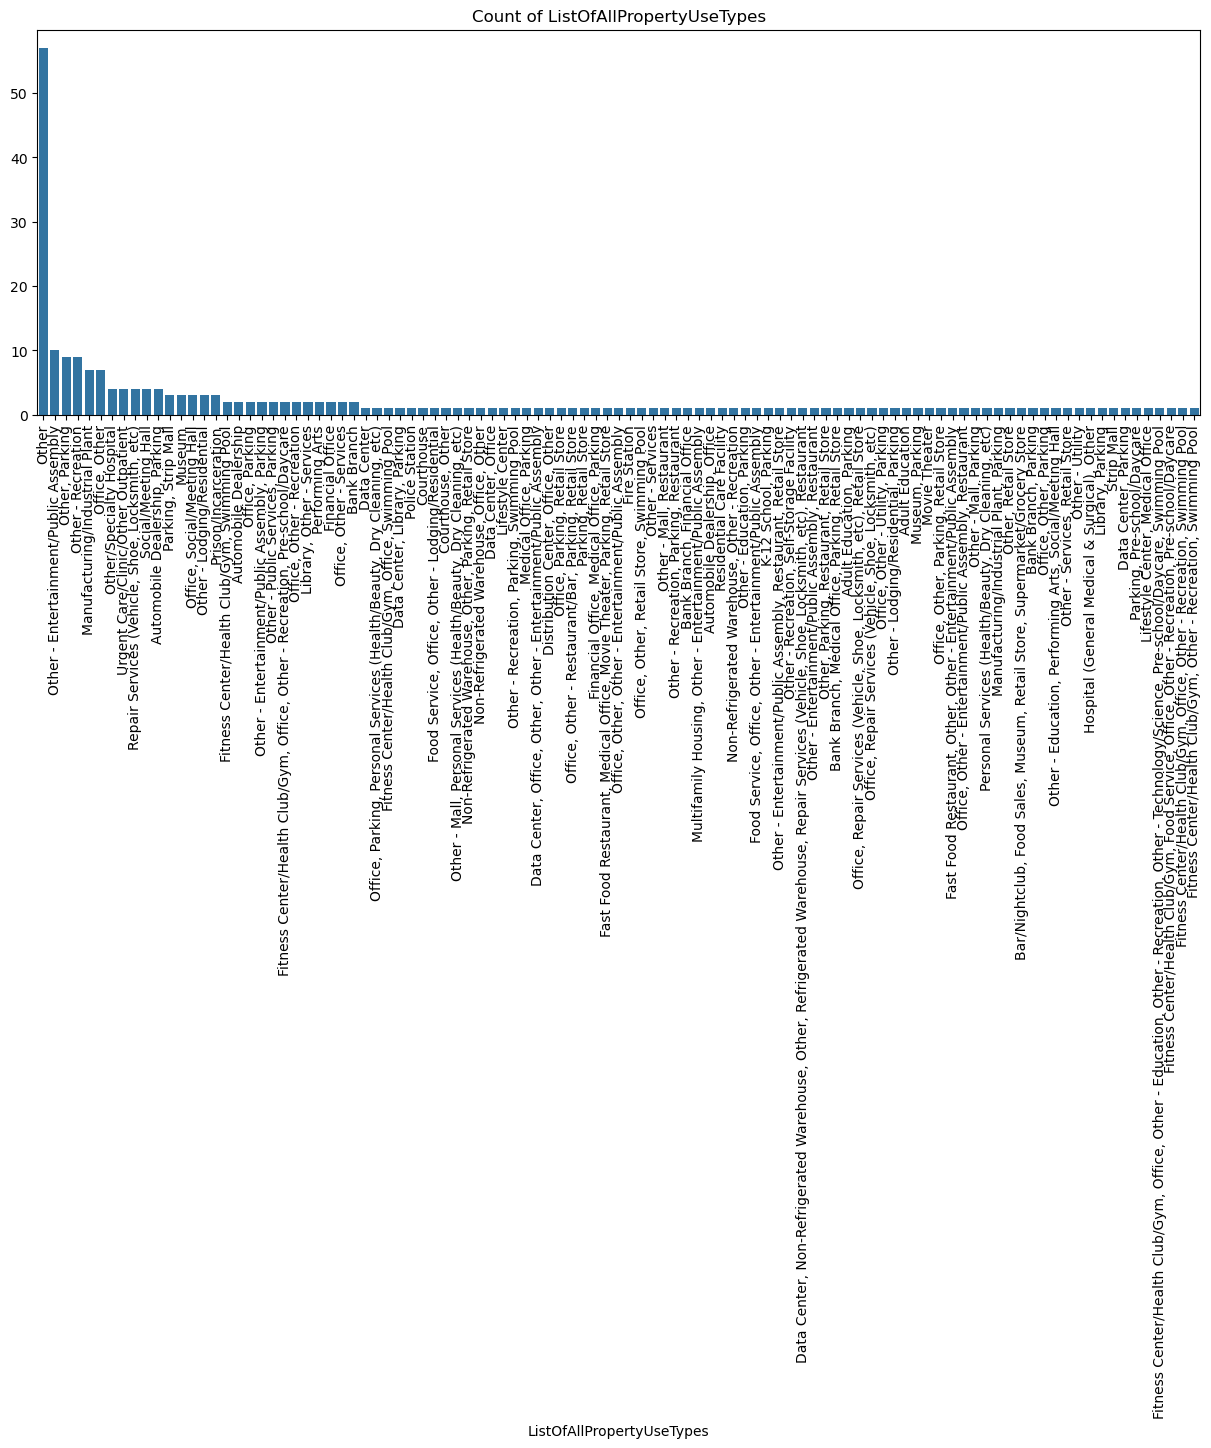

In [39]:
plot_barplots(X_clean[X_clean['PrimaryPropertyType'] == 'Other'], ['ListOfAllPropertyUseTypes'])

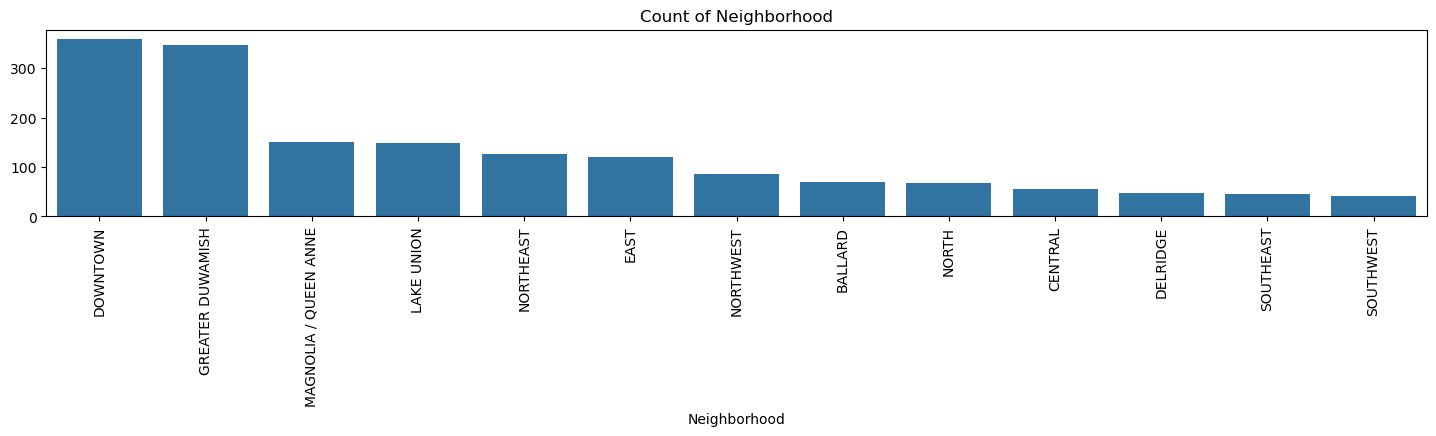

In [25]:
X_clean['Neighborhood'] = X_clean['Neighborhood'].str.upper()
X_clean['Neighborhood'] = X_clean['Neighborhood'].str.replace('DELRIDGE NEIGHBORHOODS', 'DELRIDGE')
plot_barplots(X_clean, ['Neighborhood'])

In [26]:
X_clean[main_features + numeric_columns].describe()

,TotalGHGEmissions,SiteEnergyUse(kBtu),NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),YearBuilt
count,1666.00,1666.00,1666.00,1666.00,1666.00,1666.00
mean,184.97,8437933.22,1.17,4.12,106021.56,1961.96
std,751.98,30243803.39,2.93,6.57,284372.61,32.74
min,-0.80,0.00,0.00,0.00,3636.00,1900.00
25%,19.97,1229290.84,1.00,1.00,28494.00,1930.00
50%,49.58,2554947.25,1.00,2.00,47391.50,1965.00
75%,142.38,6913348.50,1.00,4.00,94853.25,1989.00
max,16870.98,873923712.00,111.00,99.00,9320156.00,2015.00


GHG min -0.80 is not possible, actually the bigest building in seattle have 76 floor, the 111 buildings is campus so is possible.

In [29]:
thresholds = {
	'NumberofBuildings' : (0, 112),
    'NumberofFloors' : (0, 77),
    'PropertyGFABuilding(s)' : (0, 9320157),
    'TotalGHGEmissions' : (0, 16871),
    'SiteEnergyUse(kBtu)' : (0, 873923713)
}

X_imputed = treat_outliers(X_clean, thresholds)
X_imputed[main_features + numeric_columns].describe()

,TotalGHGEmissions,SiteEnergyUse(kBtu),NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),YearBuilt
count,1580.00,1580.00,1580.00,1580.00,1580.00,1580.00
mean,176.73,7872136.55,1.13,4.13,98014.99,1961.67
std,716.73,21877841.97,1.14,6.24,167189.46,32.76
min,0.12,16808.90,1.00,1.00,3636.00,1900.00
25%,20.09,1240257.50,1.00,1.00,28302.00,1930.00
50%,49.22,2549435.12,1.00,2.00,46412.50,1965.00
75%,136.27,6847524.62,1.00,4.00,93568.75,1989.00
max,16870.98,448385312.00,27.00,76.00,2200000.00,2015.00


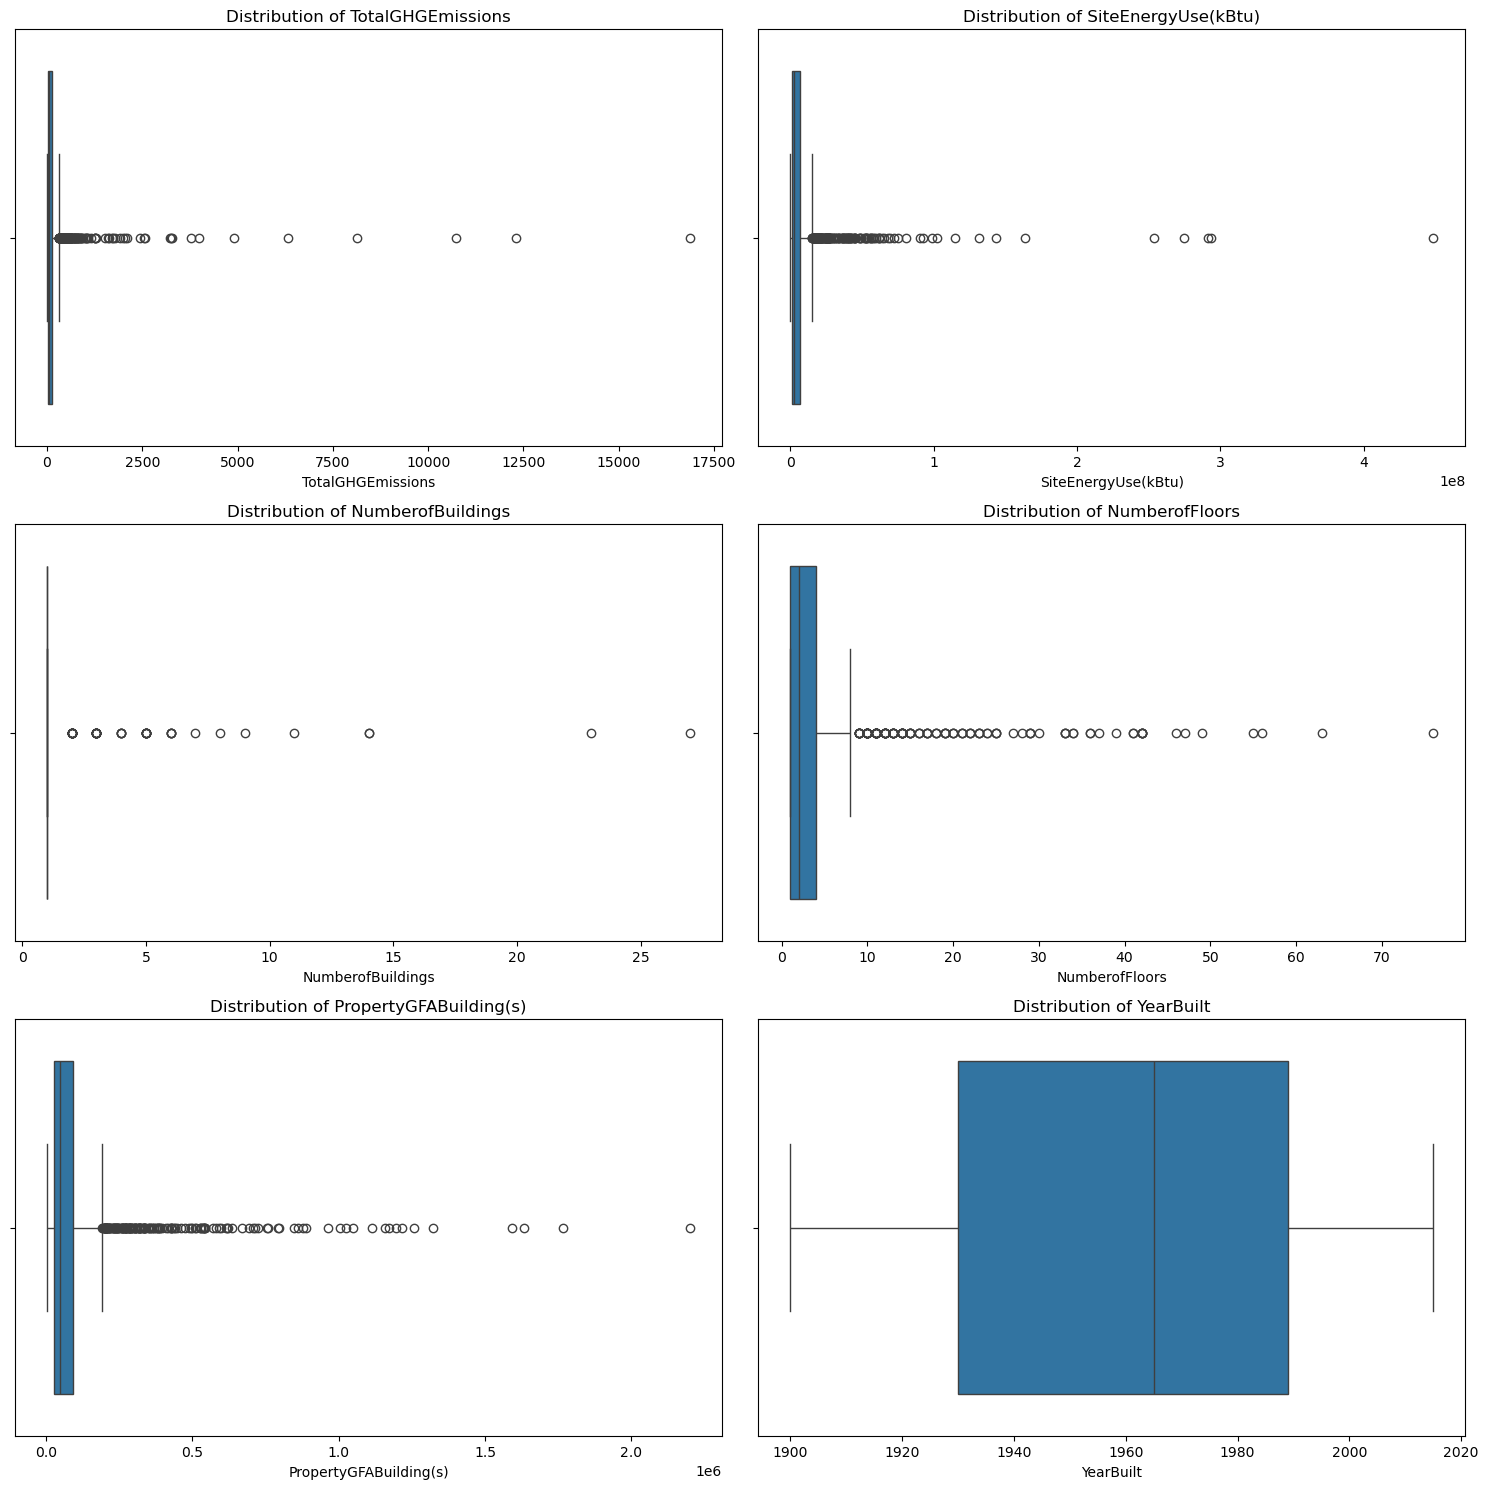

In [30]:
plot_boxplots(X_imputed, main_features + numeric_columns)

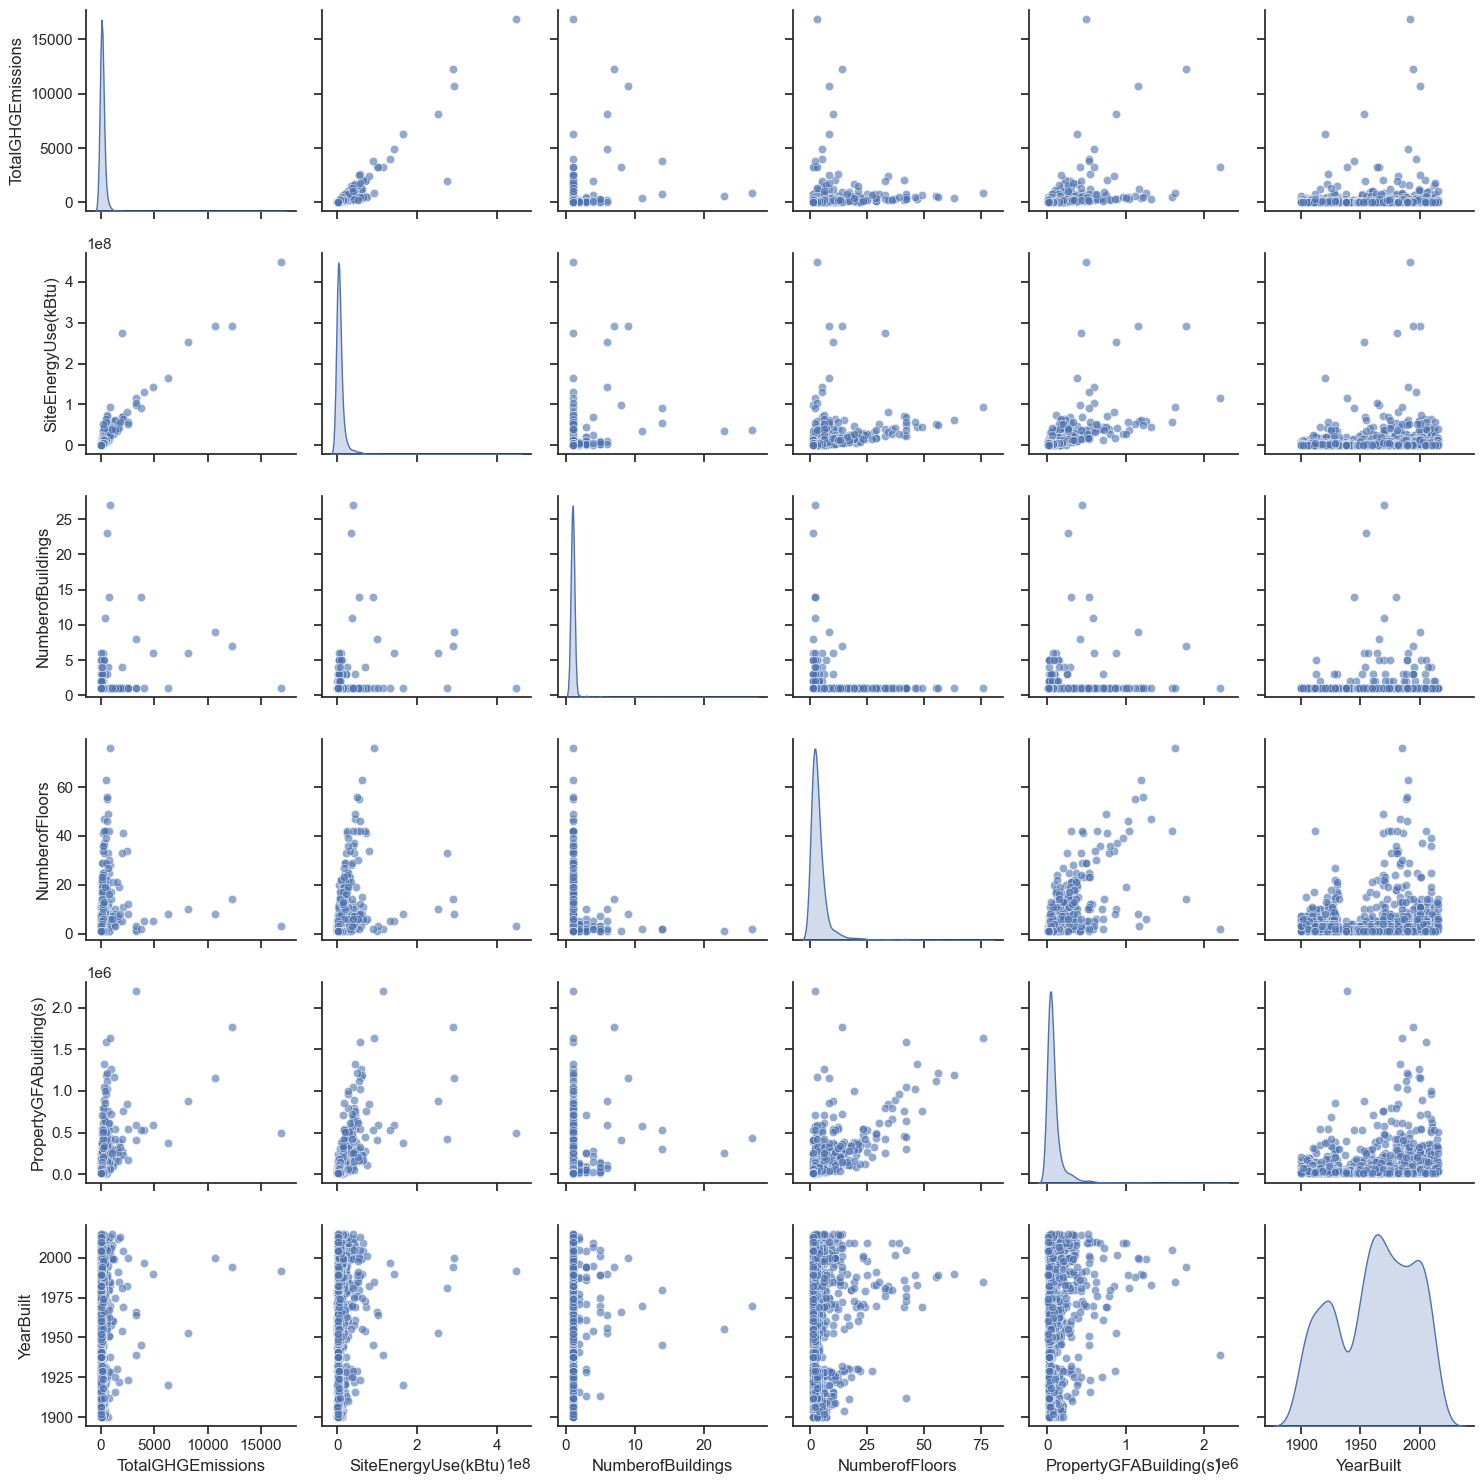

In [41]:
plot_pairplots(X_imputed, main_features + numeric_columns)

qualitative_columns = ['PrimaryPropertyType',
                       'BuildingType',
                       'Neighborhood',
                       ]

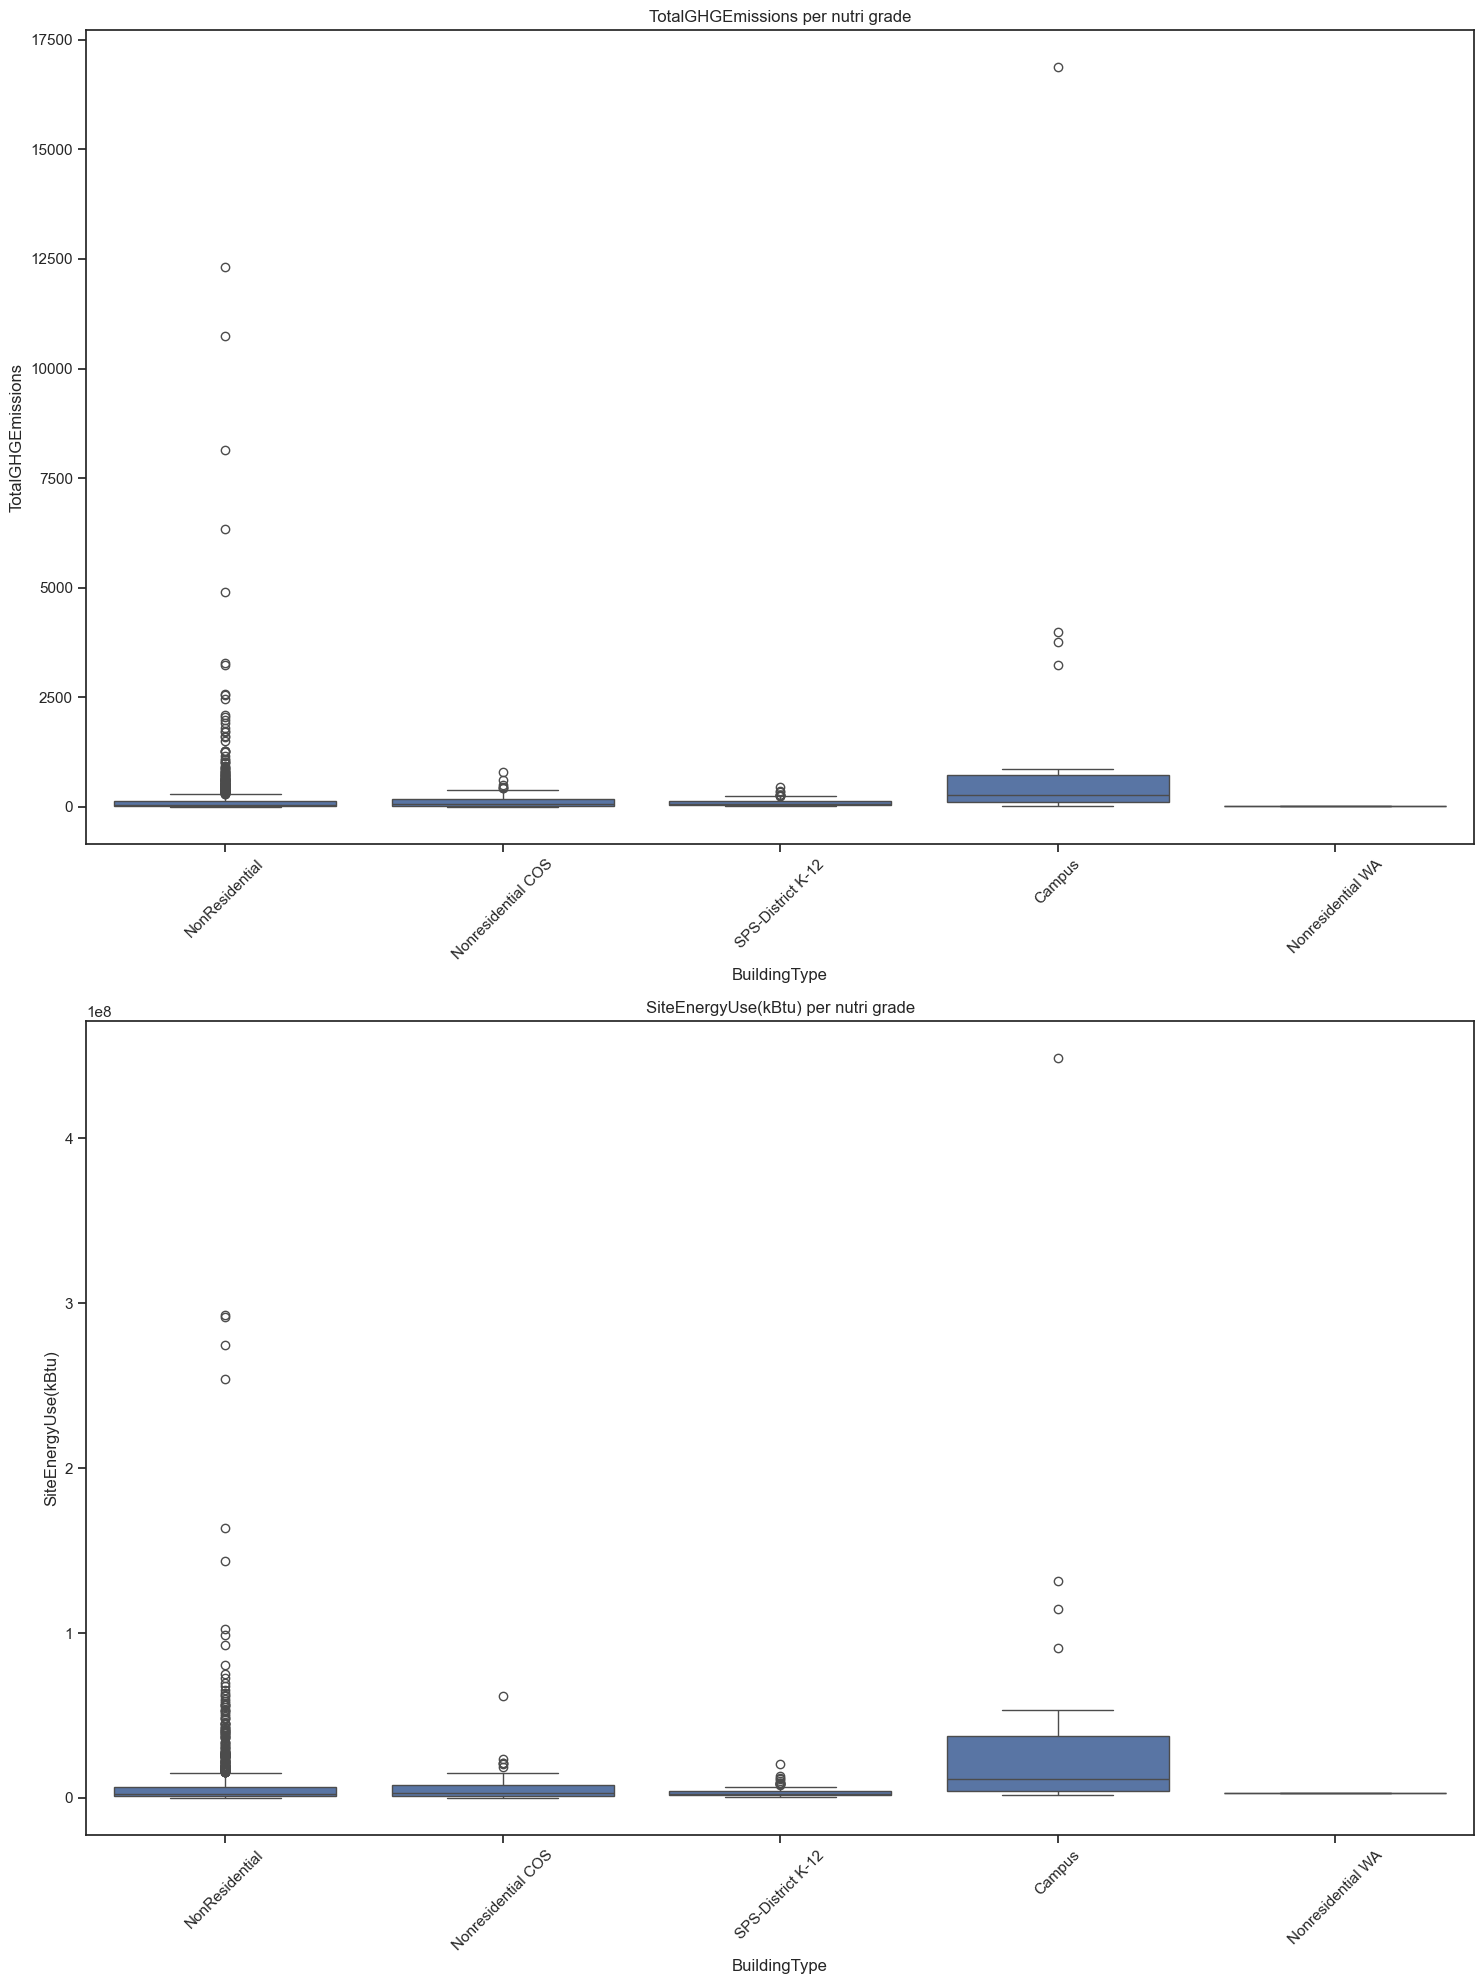

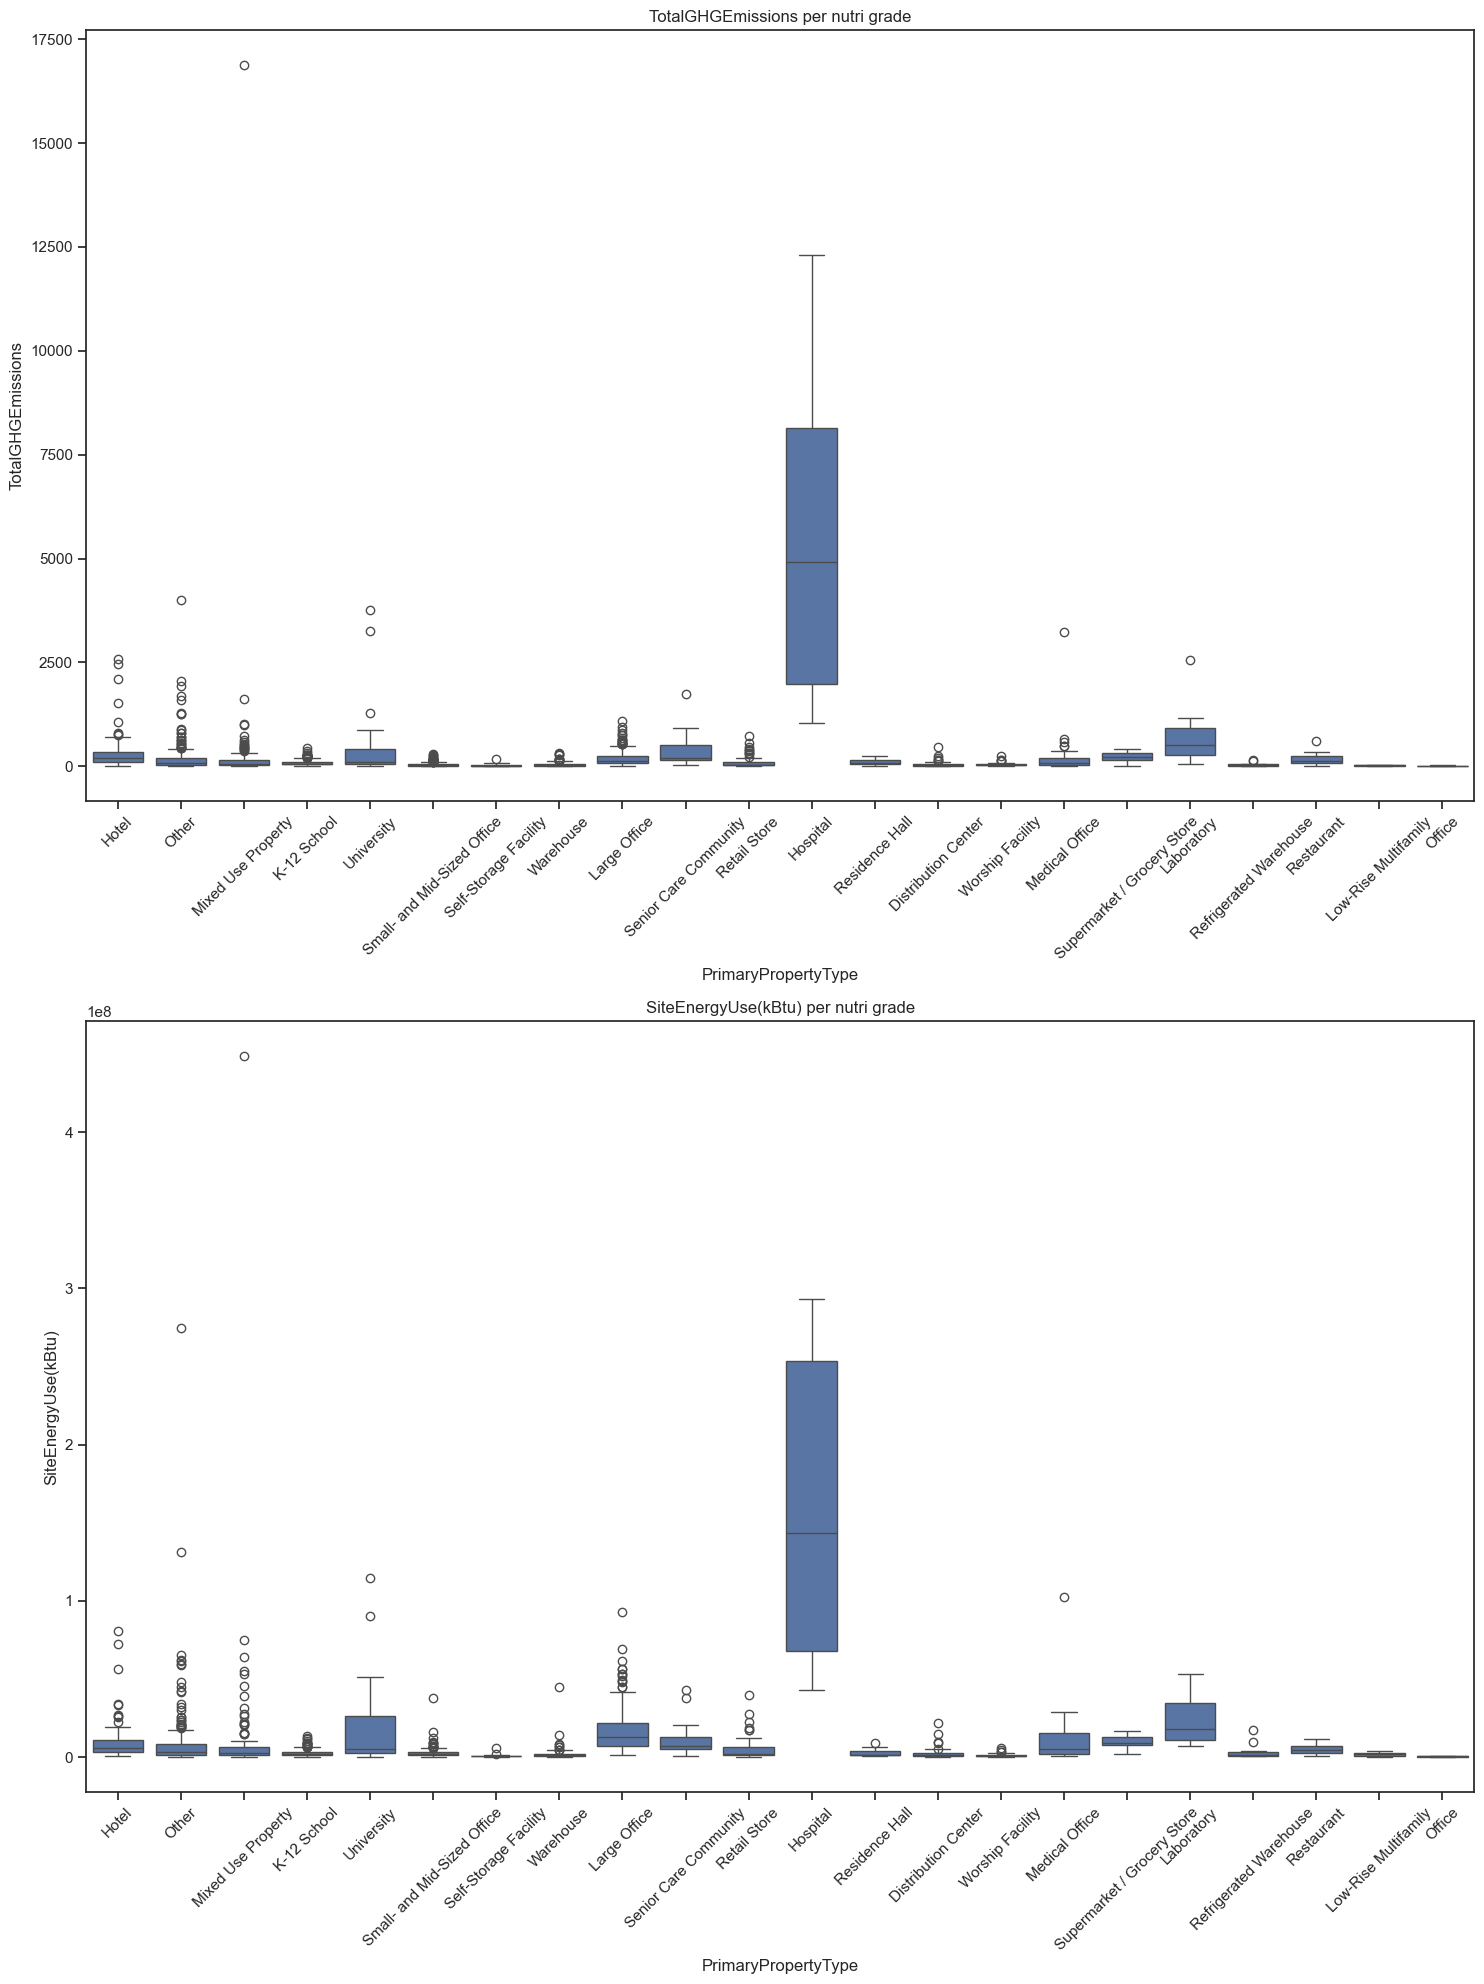

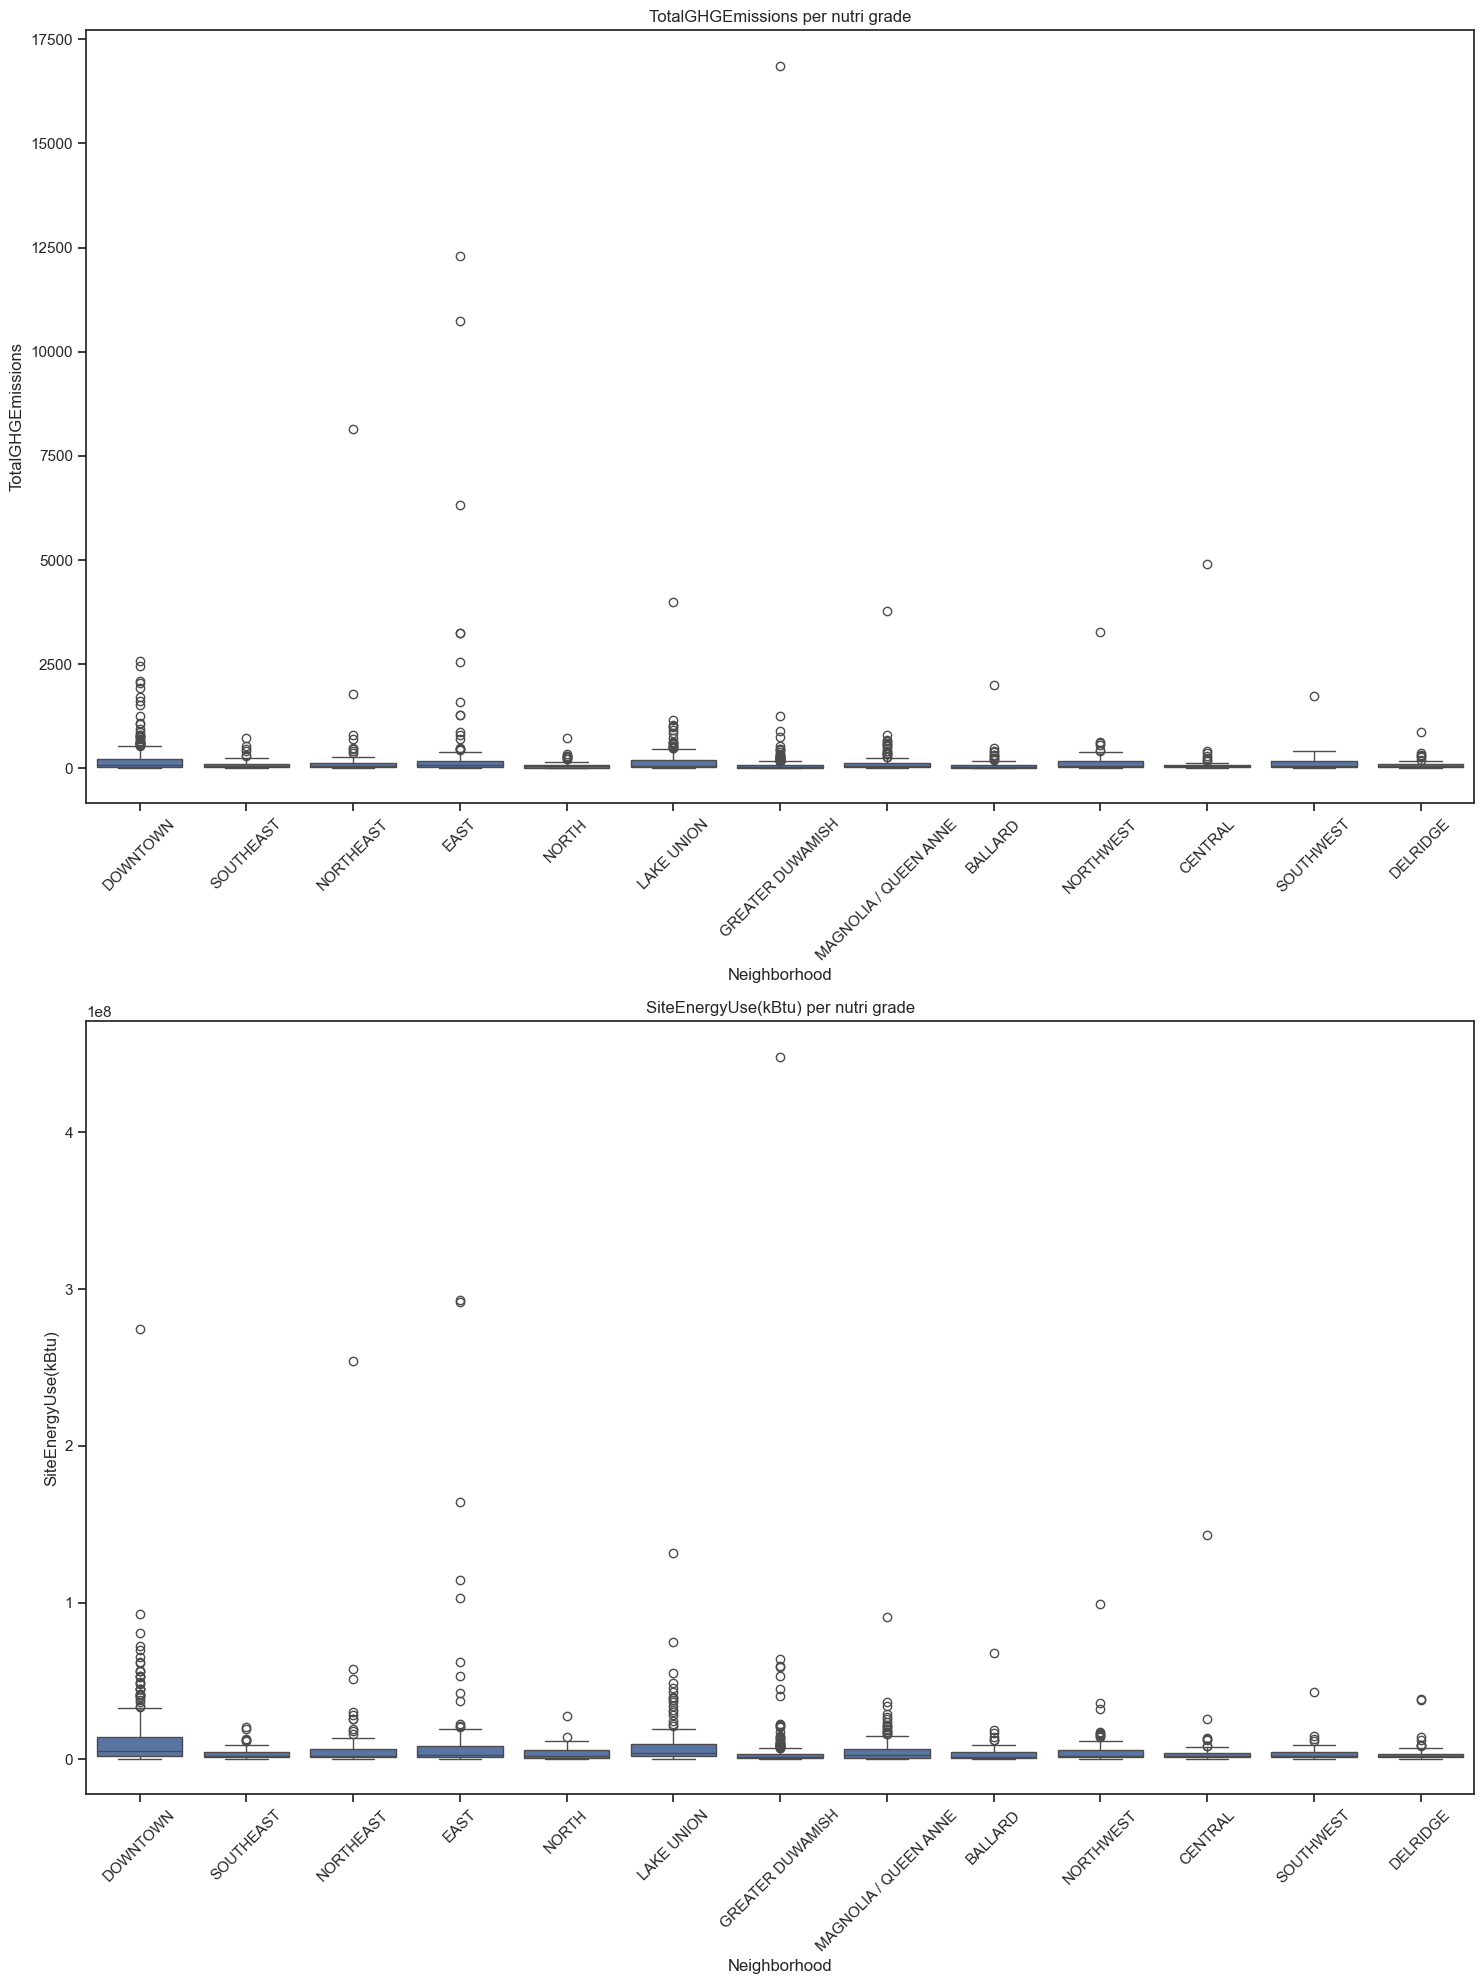

In [50]:
multi_boxplots('BuildingType', X_imputed[main_features], X_imputed['BuildingType'], main_features)
multi_boxplots('PrimaryPropertyType', X_imputed[main_features], X_imputed['PrimaryPropertyType'], main_features)
multi_boxplots('Neighborhood', X_imputed[main_features], X_imputed['Neighborhood'], main_features)

'TotalGHGEmissions' : (0, 16871),
    'SiteEnergyUse(kBtu)'

Cumulative variance ratio for 2 components: 69.27%
component 3: 23.72%


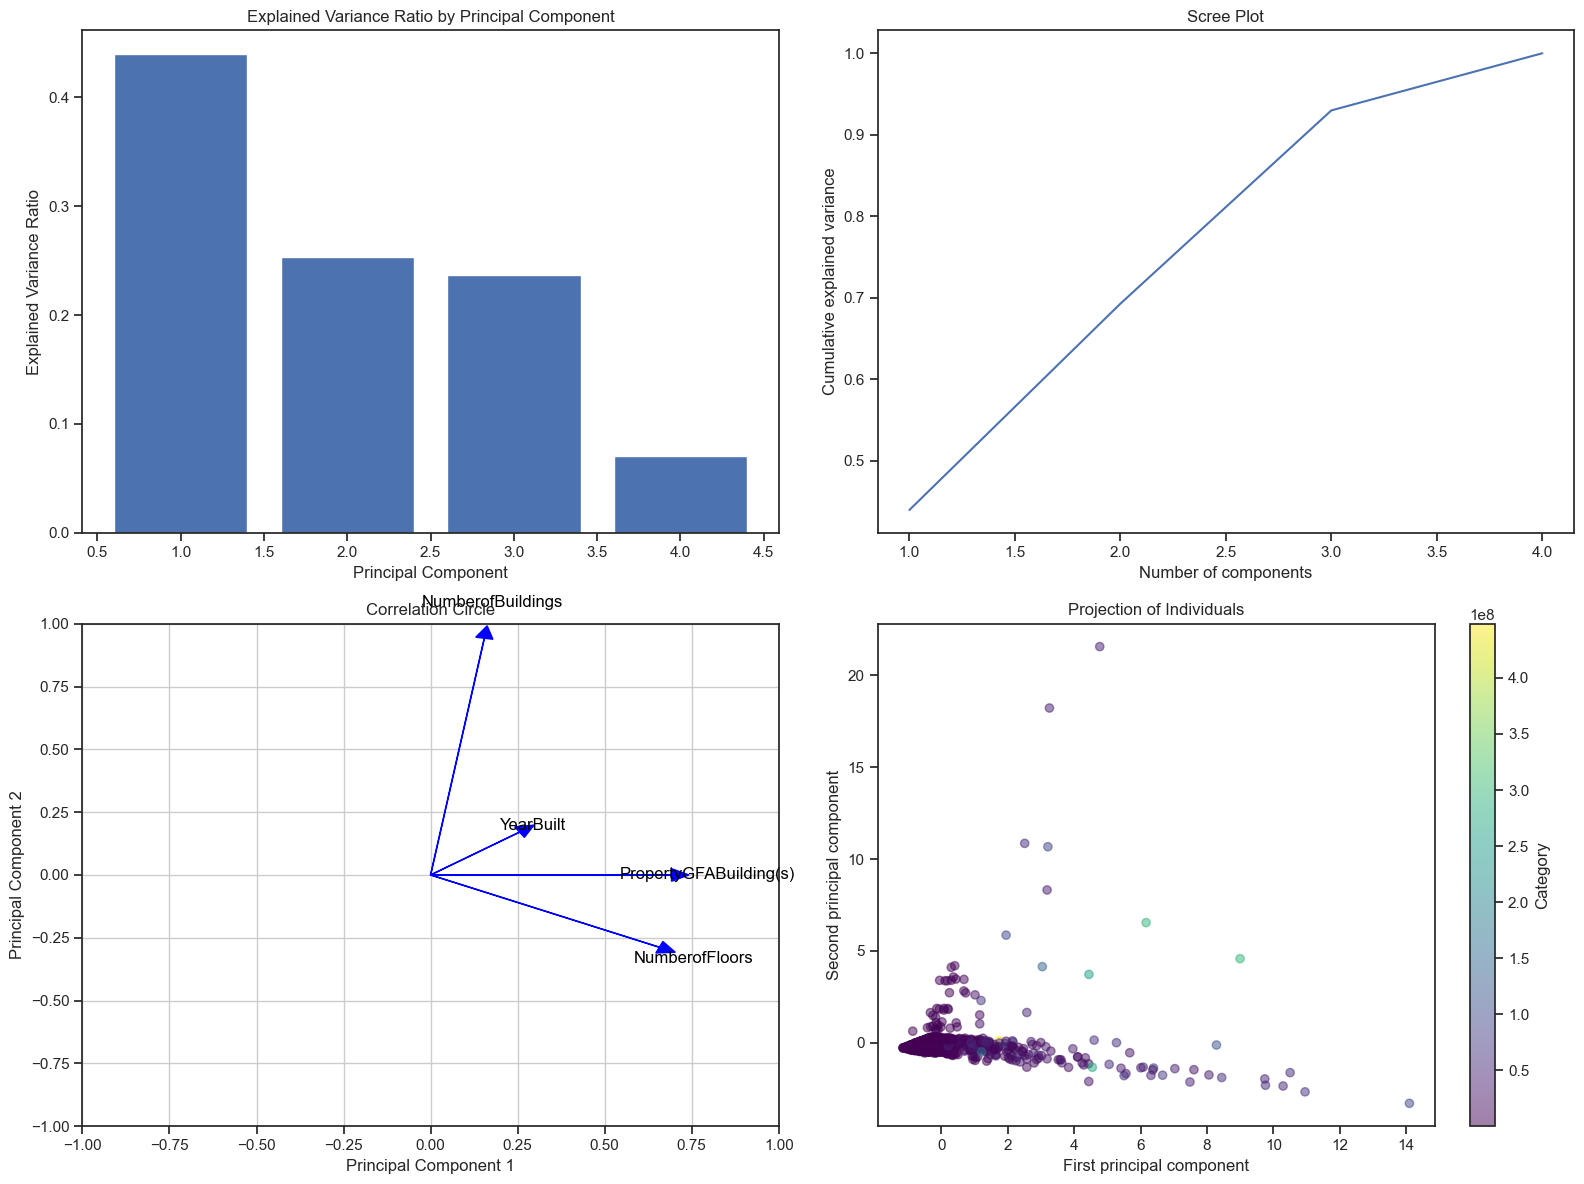

Cumulative variance ratio for 2 components: 69.27%
component 3: 23.72%


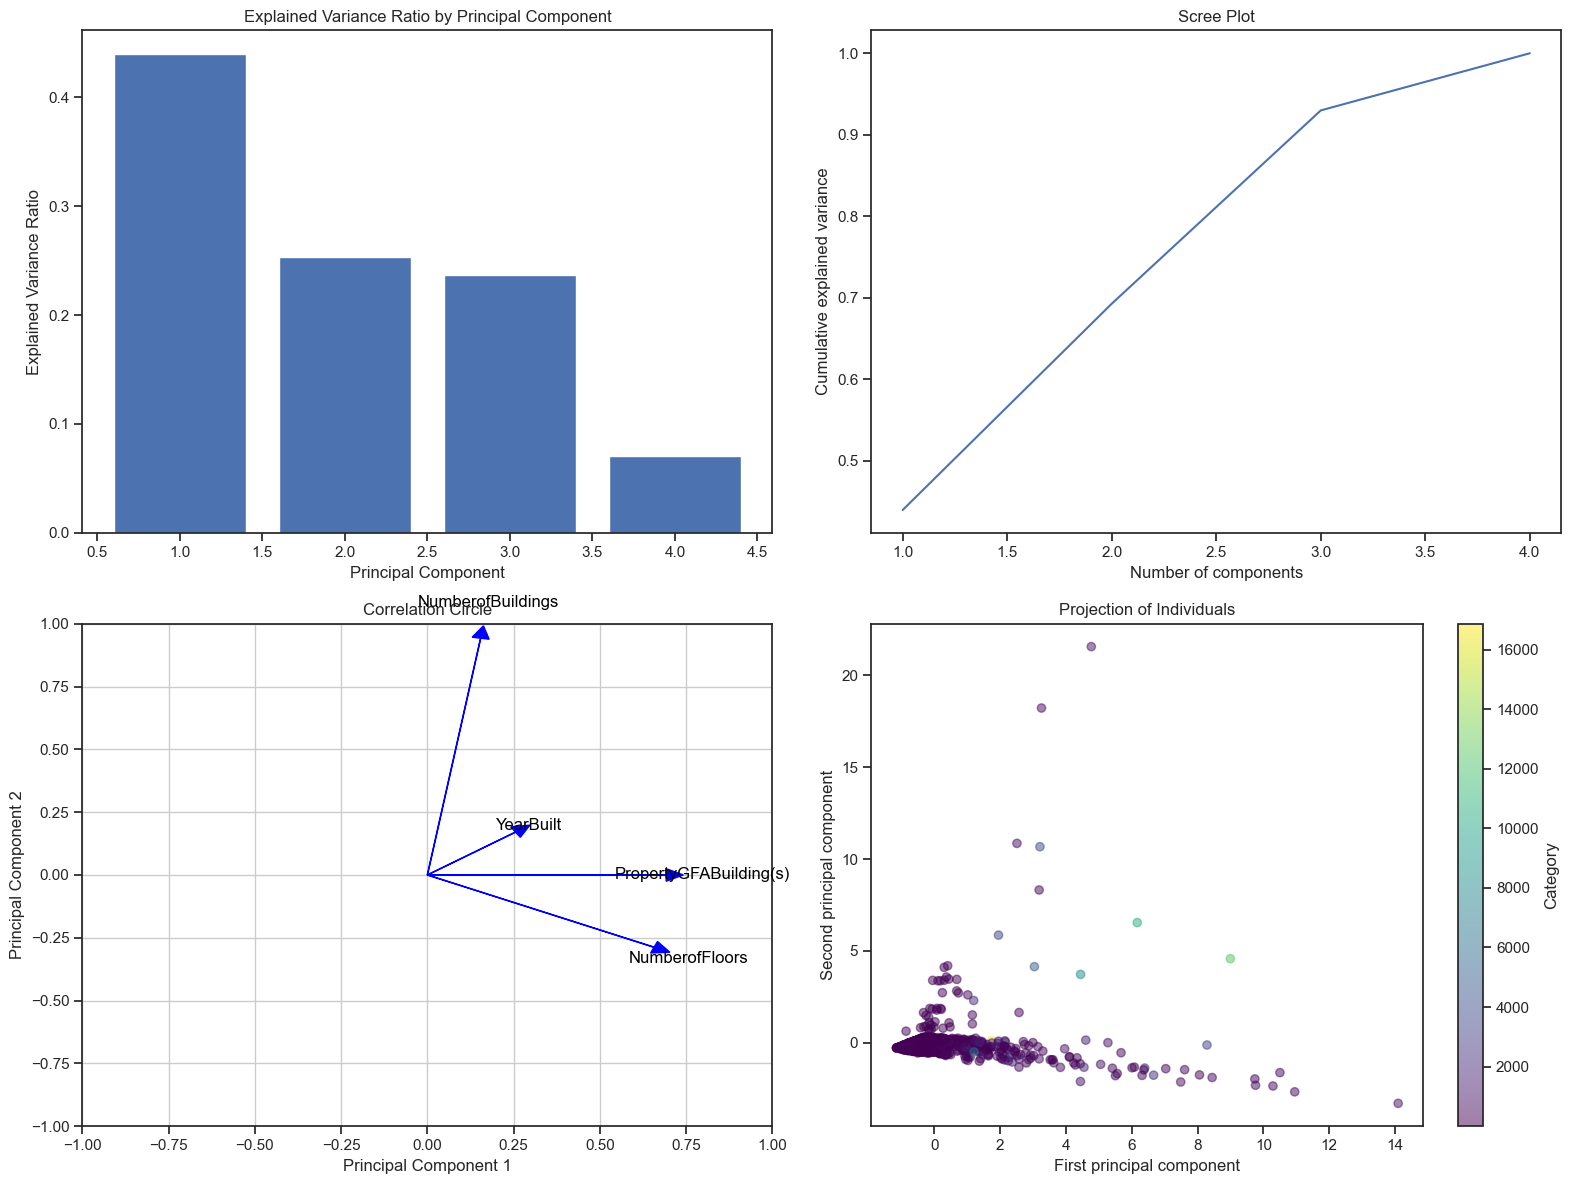

In [59]:
plot_scaler(X_imputed, numeric_columns, X_imputed['SiteEnergyUse(kBtu)'])
plot_scaler(X_imputed, numeric_columns, X_imputed['TotalGHGEmissions'])